# 7. Testing "vanilla" random forest regressor as baseline

#### In this notebook:
- I test the random forest model on the unique dataset I created from scratch
- I implement this model again in the next notebook along with the XGBoost regressor

In [285]:
from pathlib import Path
import warnings
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [2]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [4]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [391]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   hour                                            48168 non-null  int32   
 1   day_of_week                                     48168 non-null  int32   
 2   day_of_month                                    48168 non-null  int32   
 3   day_of_year                                     48168 non-null  int32   
 4   week_of_year                                    48168 non-null  int32   
 5   month_number                                    48168 non-null  int32   
 6   year                                            48168 non-null  int32   
 7   meteorological_season                           48168 non-null  category
 8   public_holiday                                  48168 non-n

#### Separate unweighted and weighted ERA5 features into separate dataframes

In [392]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later

# My 9 weighted ERA5 features
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# My 9 unweighted ERA5 features
unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

#### Remove columns to test feature and permutation importance

In [393]:
# df_weighted.drop(columns=
#                  ['weighted_mean_wind_speed_100m',
#                   'weighted_mean_wind_speed_10m',
#                   'weighted_wind_gusts_10m',
#                   'residual_load_smard_mwh',
#                  ], inplace=True)

# df_unweighted.drop(columns=
#                    ['mean_wind_speed_100m',
#                     'mean_wind_speed_10m',
#                     'wind_gusts_10m',
#                     'residual_load_smard_mwh',
#                    ], inplace=True)

-----

## Somewhat "vanilla" random forest regressor
- This is just to set a baseline RMSE score that I can improve upon using more advanced techniques
- I've chosen the start of 2023 at my split point
    - That means c. 90% train data and c. 10% test data

#### Plot the train and test split to better visualise the split

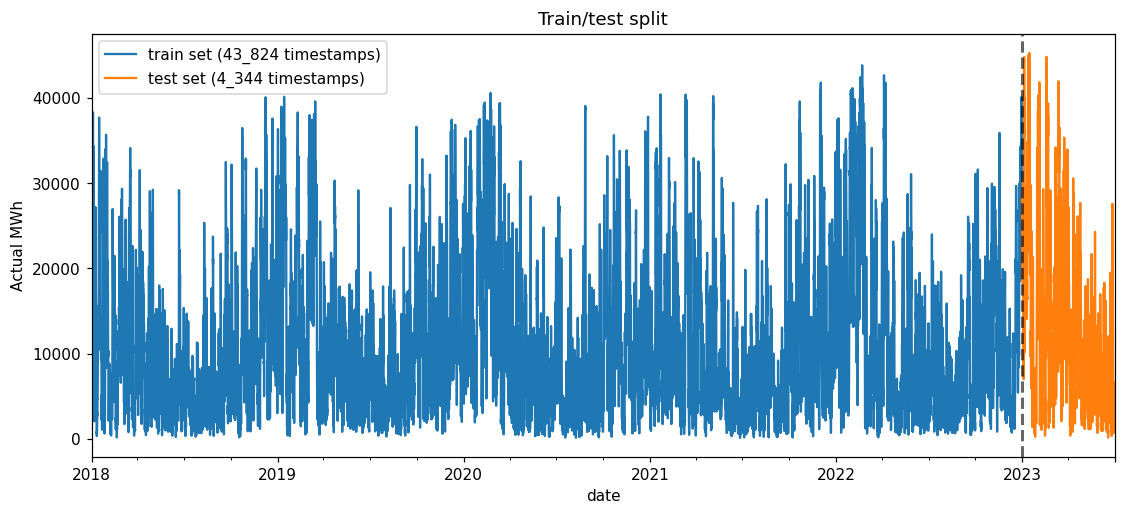

In [394]:
split_date = '2023-01-01'

# Separate train and test sets on chosen date
train_set = df.loc[df.index < split_date]
test_set = df.loc[df.index >= split_date]

# Plot the split
fig, ax = plt.subplots(figsize=(12,5))

train_set['actual_generated_smard_mwh'].plot(ax=ax, label='training set', title='Train/test split')
test_set['actual_generated_smard_mwh'].plot(ax=ax, label='test set')

ax.axvline('2023-01-01', color='black', ls='--', linewidth=2, alpha=0.6)
ax.legend(['train set (43_824 timestamps)', 'test set (4_344 timestamps)'])
ax.set_xlabel('date')
ax.set_ylabel('Actual MWh')

plt.show()

#### Function that assigns X & y and creates a pipeline with a column transformer and random forest regressor as steps

In [395]:
def create_pipeline_and_sets_using_df(df, split_date='2023-01-01'):
    """
    Input is either the unweighted or weighted dataframe
    Output is the pipeline object and X & y train-test sets
    """
    # Separate train and test sets on chosen date
    train_set = df.loc[df.index < split_date].copy()
    test_set = df.loc[df.index >= split_date].copy()

    # Assign my train sets
    X_train = train_set.drop(columns=['actual_generated_smard_mwh'])
    y_train = train_set['actual_generated_smard_mwh']

    # Assign my test sets
    X_test = test_set.drop(columns=['actual_generated_smard_mwh'])
    y_test = test_set['actual_generated_smard_mwh']

    # List of categorical features for ordinal encoding
    # Get from df as column names depend on if using weighted or unweighted df
    categorical_features = df.select_dtypes('category').columns.to_list()

    # the unique values for each categorical feature; must be in order of list above
    categories = [
        # meteorological_season
        ['winter', 'spring', 'summer', 'autumn'],
        # wind_direction_intercardinal_10m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
        # wind_direction_intercardinal_100m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    ]

    # Instantiate ordinal encoder and provide unique categories (could also use defaul of auto)
    ordinal_encoder = OrdinalEncoder(categories=categories)
    
    # Features to one-hot encode
    one_hot_features = ['meteorological_season']
    one_hot_features.extend(df.filter(regex='inter', axis=1).columns.to_list())
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Create pipeline object with named steps
    rf_pipeline = Pipeline([
        # Step 1: run categorical features through ordinal encoder
        ('transformer',
            ColumnTransformer(
            transformers=[
                ('categorical', ordinal_encoder, categorical_features),
                # ('one_hot', one_hot_encoder, one_hot_features), 
            ],
            remainder='passthrough',
            verbose_feature_names_out=False,
        )),
        # Step 2: instantiate random forest regressor
        ('model', RandomForestRegressor(
            n_estimators=100,
            max_depth=8,
            verbose=0,
            n_jobs=-1,
        )),
    ], verbose=2).set_output(transform='pandas')
    
    return rf_pipeline, X_train, y_train, X_test, y_test

#### Create function to fit and score the pipeline/model

In [396]:
def fit_and_score_model(pipeline, X_train, y_train, X_test, y_test):
    # fit model to the train data (via pipeline object)
    pipeline.fit(X_train, y_train)
    # make target predictions using test set
    y_preds = pipeline.predict(X_test)
    # calculate RMSE error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE of model predictions: {rmse:.2f}')
    # return pipeline with fitted model inside
    return pipeline

#### Run the function and get RMSE score of test set for both `df_unweighted` and `df_weighted`

##### RMSE score using `df_unweighted`

In [397]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_unweighted)
# Fit and score my model
rf_pipeline_unweighted = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.1s
RMSE of model predictions: 2307.60


##### RMSE score using `df_weighted`

In [398]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_weighted)
# Fit and score my model
rf_pipeline_weighted = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.7s
RMSE of model predictions: 2017.96


------

## Feature and permutation importances

In [399]:
# Set number of times to repeat shuffling/permutations
n_repeats = 10

In [422]:
def get_feature_and_permutation_importances(pipeline, df, n_repeats=n_repeats):
    fitted_model = pipeline['model']
    # Get model's feature names in
    feature_names = fitted_model.feature_names_in_
    # Get model's feature importances
    feature_importances = fitted_model.feature_importances_
    
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    # Run X through ordinal encoding to prep for permutation importance
    X_transformed = pipeline['transformer'].fit_transform(X)
    y = df['actual_generated_smard_mwh'].copy()
    
    # Verify that feature names are in the same order
    print(f'Feature names equal: {np.array_equal(feature_names, np.array(X_transformed.columns))}')
    
    # Calculate permutation importances on the already-fitted model
    permutation_result = permutation_importance(
        fitted_model, 
        X_transformed, 
        y,
        scoring='neg_root_mean_squared_error',
        n_repeats=n_repeats, 
        random_state=0
    )
    
    # Create pandas df of mean permutation importances and their standard deviations
    df_importances = pd.DataFrame(data={
        'feature_importances': feature_importances,
        'permutation_importances_mean': permutation_result.importances_mean,
        'permutation_importances_std': permutation_result.importances_std
    }, index=feature_names)
    
    # Min-max normalise for better visualisation
    df_importances[['feature_importances_norm', 'permutation_importances_mean_norm']] = MinMaxScaler().fit_transform(
        df_importances[['feature_importances', 'permutation_importances_mean']]
    )
    
    # Sort dataframe for plotting
    df_importances.sort_values(by='permutation_importances_mean', ascending=True, inplace=True)
    # Round all values to better display as bar labels in plot
    df_importances = df_importances.applymap(lambda x: round(x, 4))
    
    return df_importances

In [401]:
df_importances_unweighted = get_feature_and_permutation_importances(
    rf_pipeline_unweighted,
    df_unweighted,
)

Feature names equal: True


In [402]:
df_importances_unweighted

,feature_importances,permutation_importances_mean,permutation_importances_std,feature_importances_norm,permutation_importances_mean_norm
public_holiday,0.0000,0.0032,0.0001,0.0000,0.0000
noise,0.0000,0.2669,0.0250,0.0000,0.0000
year,0.0000,0.2678,0.0392,0.0000,0.0000
month_number,0.0000,0.3915,0.0253,0.0000,0.0000
meteorological_season,0.0000,0.5033,0.0306,0.0000,0.0000
day_of_week,0.0001,1.8830,0.0753,0.0001,0.0002
week_of_year,0.0001,2.8356,0.1208,0.0001,0.0003
day_of_month,0.0001,3.4408,0.1022,0.0001,0.0003
hour,0.0001,3.6591,0.1084,0.0001,0.0004
day_of_year,0.0003,7.9518,0.1760,0.0003,0.0008


In [403]:
df_importances_weighted = get_feature_and_permutation_importances(
    rf_pipeline_weighted,
    df_weighted,
)

Feature names equal: True


In [404]:
df_importances_weighted

,feature_importances,permutation_importances_mean,permutation_importances_std,feature_importances_norm,permutation_importances_mean_norm
public_holiday,0.0000,0.0000,0.0000,0.0000,0.0000
day_of_week,0.0000,0.4775,0.0503,0.0000,0.0000
month_number,0.0000,0.6035,0.0359,0.0000,0.0001
noise,0.0000,0.7717,0.0767,0.0000,0.0001
weighted_wind_direction_intercardinal_100m,0.0000,0.9498,0.0643,0.0000,0.0001
meteorological_season,0.0000,1.3512,0.0408,0.0000,0.0001
year,0.0000,1.5458,0.1189,0.0000,0.0001
day_of_month,0.0001,2.2928,0.1037,0.0001,0.0002
weighted_wind_direction_intercardinal_10m,0.0001,2.5033,0.1346,0.0001,0.0002
weighted_mean_wind_direction_angle_100m,0.0001,4.1592,0.0775,0.0001,0.0004


In [436]:
def plot_importances(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    # df['permutation_importances_mean'].plot.barh(xerr=df['permutation_importances_std'], ax=ax)
    df[['feature_importances_norm', 'permutation_importances_mean_norm']].plot.barh(ax=ax)
    ax.set_title('Feature and permutation importances (weighted features)', loc='left', fontweight='bold', pad=15)
    ax.set_xlabel('Importance (normalised; log scale)', fontweight='bold')

    # ax.bar_label(
    #     ax.containers[1],
    #     labels=df['permutation_importances_mean'], 
    #     padding=5,
    #     fontsize=8,
    #     color='tab:blue',
    # )
    # ax.set_xlim(right=df['permutation_importances_mean'].max()+1000)
    
    ax.legend(loc='center right', frameon=False)
    ax.set_xscale('log')
    
    # remove certain spines (the frame)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_visible(True)
    
    
    # fig.tight_layout()
    plt.show()
    
    # save figure for report
    fig.savefig(data_path.joinpath('visuals').joinpath('importances.png'), format='png', dpi=150, bbox_inches='tight')

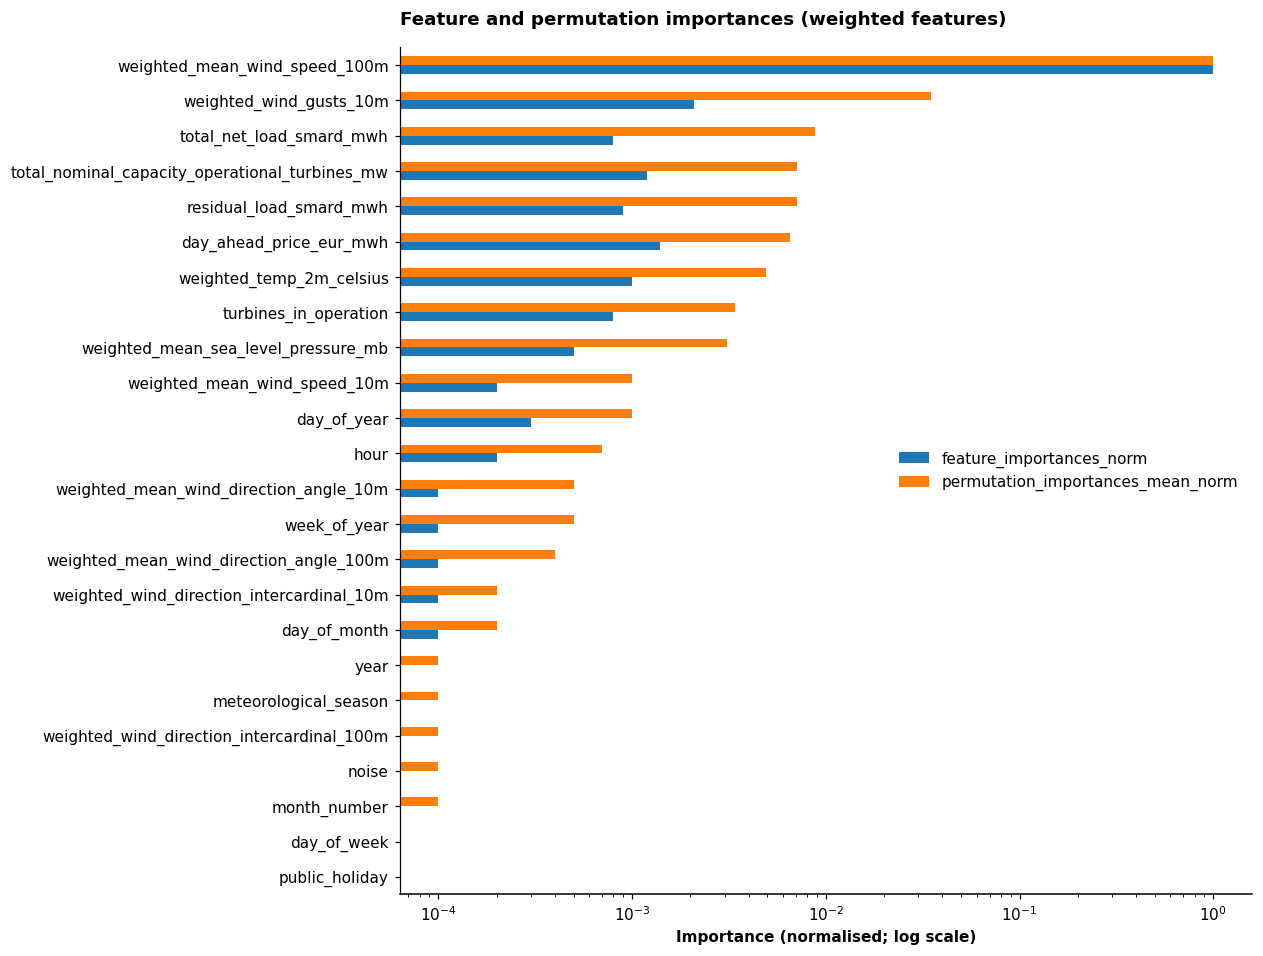

In [437]:
plot_importances(df_importances_weighted)

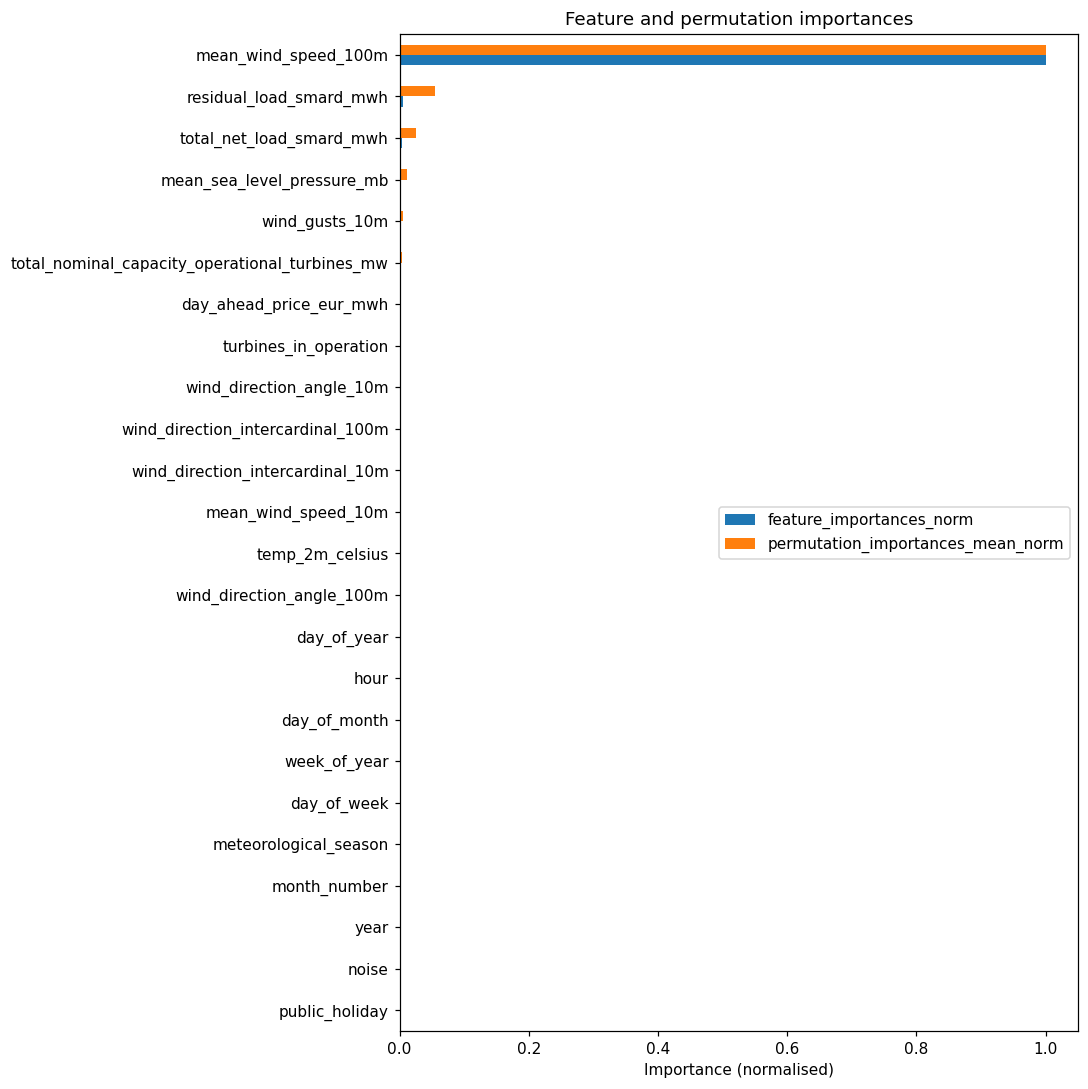

In [407]:
plot_importances(df_aimportances_unweighted)